# Convolutional Networks

In [1]:
# Setup
import tensorflow as tf
import keras

import time as timer
import datetime

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import imp

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import dataset

import utils as U
import models as M

imp.reload(U)
imp.reload(M)

/var/folders/b9/jjp98g8j2mbcn65j0fgl0dzw0000gp/T/ipykernel_73887/242233432.py:13: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'models' from '/Users/mghifary/Work/Code/AI/keras-poc/models.py'>

### Constants

In [2]:
EPOCH = 20
BATCH = 64

DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODELDIR = "/Users/mghifary/Work/Code/AI/models"

modelpath = os.path.join(MODELDIR, "fashion_mnist-lenet-classifier_temp2.h5")

In [3]:
# Load dataset
(x_train, y_train), (x_test, y_test) = dataset.load_data()

(n_train, dx1, dx2) = x_train.shape
n_test = x_test.shape[0]

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Preprocess
ds_train = dataset.preprocess_fashionmnist(ds_train, shuffle=True, augment=False, batch_size=BATCH)
ds_test = dataset.preprocess_fashionmnist(ds_test, shuffle=False, augment=False, batch_size=BATCH)

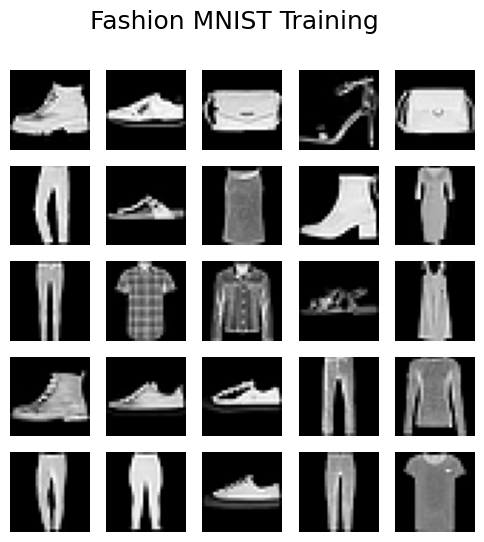

In [4]:
# Visualize training samples
U.visualize_dataset(ds_train, title="Fashion MNIST Training", n_samples=25)

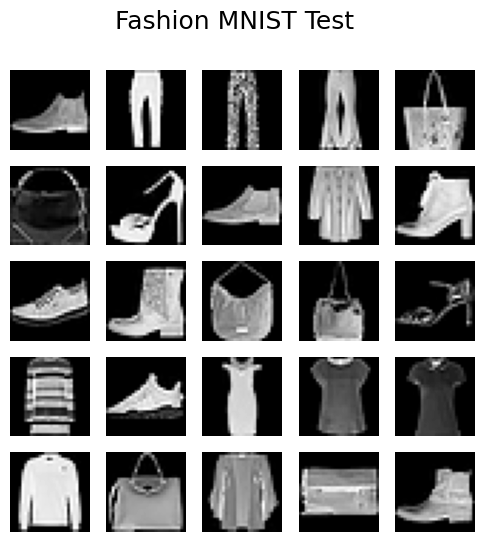

In [5]:
# Visualize test samples
U.visualize_dataset(ds_test, title="Fashion MNIST Test", n_samples=25)

In [6]:
# Build model

# # LeNet5
# inputs = keras.Input(shape=(dx1, dx2, 1))
# x = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same")(inputs)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.MaxPool2D((2, 2))(x)

# x = keras.layers.Conv2D(48, kernel_size=(5, 5), padding="valid")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.MaxPool2D((2, 2))(x)

# x = keras.layers.Flatten()(x)

# x = keras.layers.Dense(256, activation="relu")(x)
# x = keras.layers.Dense(128, activation="relu")(x)
# outputs = keras.layers.Dense(10)(x)

# model = keras.Model(inputs=inputs, outputs=outputs, name="fashion_mnist_lenet5")
# model.summary()

# Build model
model = M.LeNet5(num_classes=10, input_shape=(dx1, dx2, 1))
model.build(input_shape=(None, dx1, dx2, 1))
model.summary()

Model: "le_net5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  832       
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  38448     
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  3074

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 48)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1200)              0     

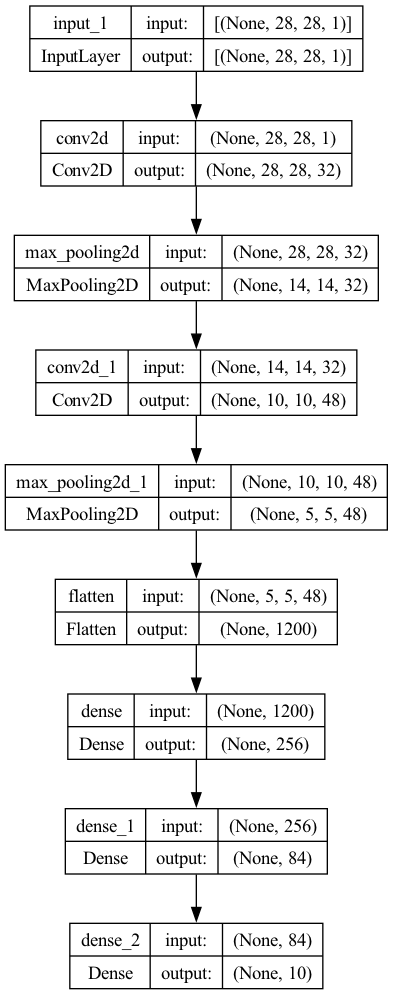

In [7]:
# Plot model
inputs = keras.Input(shape=(dx1, dx2, 1))
model_func = keras.Model(inputs, model.call(inputs))
print(model_func.summary())
modelfig_path = os.path.join(MODELDIR, "conv_fashionmnist.png")
keras.utils.plot_model(model_func, to_file=modelfig_path, show_shapes=True)

In [8]:
# # Build model
# class LeNet5(keras.Sequential):
#     """LeNet5 architecture"""

#     def __init__(self, num_classes=10):
#         super().__init__()
#         self.add(keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", input_shape=(dx1, dx2, 1)))
#         self.add(keras.layers.BatchNormalization())
#         # self.add(keras.layers.ReLU())
#         self.add(keras.layers.MaxPool2D((2, 2)))

#         self.add(keras.layers.Conv2D(48, kernel_size=(5, 5), padding="valid"))
#         self.add(keras.layers.BatchNormalization())
#         # self.add(keras.layers.ReLU())
#         self.add(keras.layers.MaxPool2D((2, 2)))

#         self.add(keras.layers.Flatten())

#         self.add(keras.layers.Dense(256, activation="relu"))
#         self.add(keras.layers.Dense(128, activation="relu"))
#         self.add(keras.layers.Dense(num_classes))

# model = LeNet5(num_classes=10)
# model.build(input_shape=(None, dx1, dx2))
# model.summary()

Train model

In [9]:
# Loss and optimizer
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.legacy.Adam(learning_rate=3e-4)


In [10]:
# Define metrics
train_loss = keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = keras.metrics.SparseCategoricalAccuracy('train_accuracy')

test_loss = keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [11]:
# Training and test function
@tf.function
def train_on_batch(model, loss_fn, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss_value = loss_fn(y, y_pred)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_loss(loss_value)
    train_accuracy(y, y_pred)

@tf.function
def test_on_batch(model, loss_fn, x, y):
    y_pred = model(x, training=False)
    loss_value = loss_fn(y, y_pred)
    
    test_loss(loss_value)
    test_accuracy(y, y_pred)

In [12]:
# Setup summary writers
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/convnet-fashionmnist/' + current_time + '/train'
test_log_dir = 'logs/convnet-fashionmnist/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [13]:
# Do training
for epoch in range(EPOCH):
    # Mini-batch training
    train_duration = 0.0
    for step, (x, y) in enumerate(ds_train):
        start_t = timer.time()
        train_on_batch(model, loss_fn, optimizer, x, y)
        elapsed_t = timer.time() - start_t

        train_duration += elapsed_t
    
    # Store log
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    # Test
    test_duration = 0.0
    for step, (xt, yt) in enumerate(ds_test):
        start_t = timer.time()
        test_on_batch(model, loss_fn, xt, yt)
        elapsed_t = timer.time() - start_t

        test_duration += elapsed_t

    # Store log
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

    print(f"Epoch {epoch+1} - Training [loss: {train_loss.result():.5f}, accuracy: {train_accuracy.result():.3f}] ({train_duration:.3f} secs), Test [loss: {test_loss.result():.5f}. accuracy: {test_accuracy.result():.3f}] ({test_duration:.3f} secs)")

    # Save model
    model.save_weights(modelpath, overwrite=True, save_format=None, options=None)

# end of epoch

x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
x shape: (64, 28, 28, 1)
